# Table of contents
1. [The data](#data)
    1. [Import the packages](#pack)
    2. [Loading the data](#load)
    3. [Preprocessing](#prep)
2. [Time Series](#TS)
    1. [The QQ plot](#qq)
    1. [Stationarity and returns](#returns)
    2. [ACF and PACF](#ACF)
    2. [Normalization](#normalization)
    3. [Residuals](#residuals)
3. [Models](#models)
    1. [AutoRegessive models](#AR)
    1. [Moving Averages](#ma)
    3. [ARMA](#arma)
    4. [ARIMA](#ARIMA)
    5. [ARIMAX](#ARIMAX)
    6. [ARCH](#ARCH)
    7. [GARCH](#GARCH)
    4. [Auto-ARIMA](#autoarima)
4. [Forecasting](#forecasting)

# The data  <a name="data"></a>

## Import the packages <a name="pack"></a>

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2

import scipy.stats
import pylab
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.tsa.api import VAR

## Loading the data <a name="load"></a>

In [148]:
raw_data = pd.read_csv('Index2018.csv')
df_complete = raw_data.copy()

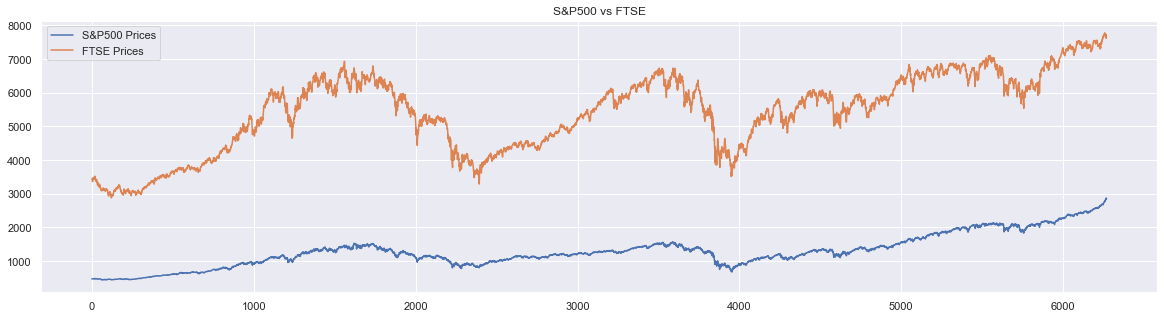

In [159]:
raw_data.spx.plot(figsize=(20,5), label = 'S&P500 Prices')
raw_data.ftse.plot(figsize=(20,5), label = 'FTSE Prices')
plt.title('S&P500 vs FTSE')
plt.legend()
plt.show()

## Preprocessing <a name="prep"></a>

In [149]:
df_complete.date = pd.to_datetime(df_complete.date, dayfirst = True)
df_complete.set_index('date', inplace = True)
df_complete = df_complete.asfreq('b')
df_complete = df_complete.fillna(method = 'ffill')

A comment on the fillna methods:
- front filling: assigns the value of the previous period
- back filling: assigns the value of the next period
- assigning the same value: average of all the missing values for the time series (BETTER NOT)

In [150]:
df_complete['market_value'] = df_complete.ftse

In [152]:
# del df['dax'], df['ftse'], df['nikkei']
size = int(len(df_complete)*0.8)
df, df_test = df_complete.iloc[:size], df.iloc[size:]

# Time Series <a name="TS"></a>

## The QQ plot <a name="qq"></a>

- arranges the data in order of prices (y-axis)

- x-axis: theoretical quantile - how many standard deviations away from the mean the values are

- line: what data should follow if they are normally distributed. In this case they aren't.

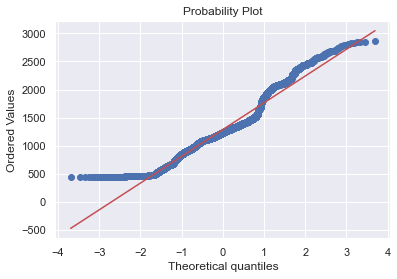

In [164]:
scipy.stats.probplot(raw_data.spx, plot = pylab)
pylab.show()

## Seasonality

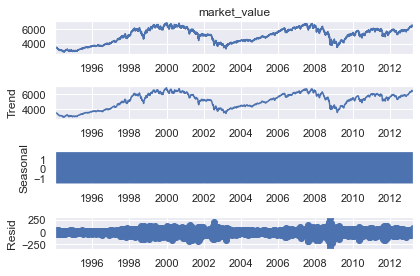

In [168]:
s_dec_additive = seasonal_decompose(df.market_value, model = 'additive')
s_dec_additive.plot()
plt.show()

Residuals are higher in 2000 and in 2008 (market turbolence). 
No seasonality in the data

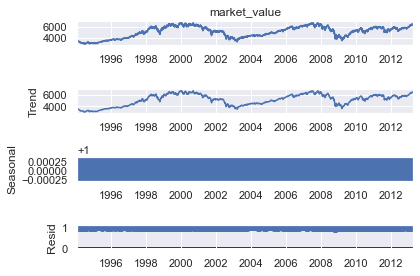

In [169]:
s_dec_mult = seasonal_decompose(df.market_value, model = 'multiplicative')
s_dec_mult.plot()
plt.show()

## Stationarity and returns  <a name="returns"></a>

DF test --> H_0 : non-stationarity

- test statistic = -1,7 to compare with critical value
- p value associated to the t-statistic
- number of lags used to determine the t-statistic (18 periods)
- number of observations used in the analysys (5002) NB: 18+5002 = len(df)
- 1,5,10% critical values of DF table - to be used as levels of significance
- maximized inform cryteria provided there is autocorr. lower value --> easier to make prediction for the future

There is no evidence to reject the null hypothesis, no evidence for non stationarity. Indeed, the p value = 0.33 is not lower than every level of significance (0.05, 0.01,..)-> cannot reject. 

In [8]:
# DF test
sts.adfuller(df.market_value)

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

Non stationary :(

In finance it is common to use returns instead of prices, which are more likely to be stationary. Let's see how to create them:

$ ret_t = \frac{P_t - P_{t-1}}{P_{t-1}} *100 $

In [155]:
df['returns'] = df.market_value.pct_change(1).mul(100)

df = df.iloc[1:] # the first element is obviously NaN

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [156]:
sts.adfuller(df.returns)

(-12.770265719497184,
 7.79805833604023e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.7672456975)

stationary! :)

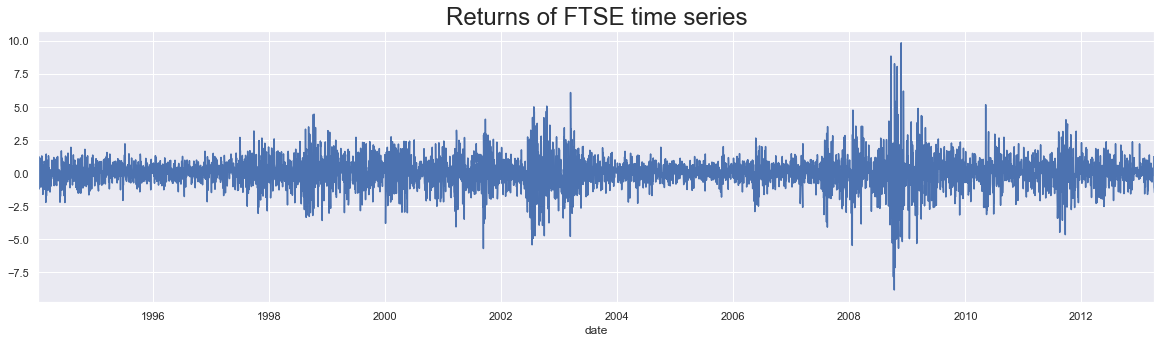

In [157]:
df.returns.plot(figsize=(20,5))
plt.title('Returns of FTSE time series', size = 24)
plt.show()

## ACF and PACF  <a name="ACF"></a>

x-asis --> the lags
y-axis --> autocorrelation of the TS with a lagged version of itself

blue area --> significance: outside of this area there is significance for autocorrelation

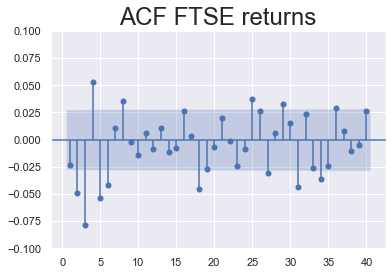

In [20]:
sgt.plot_acf(df.returns, lags = 40, zero = False)
plt.ylim(-0.1,0.1)
plt.title('ACF FTSE returns', size=24)
plt.show()

PACF cancels out all additional channels a previous period value affects the present one. Computes correlation betw 
$ X_{t-2} $ and $ X_t $ but cancels out 
$ X_{t-2} -> X_{t-1} -> X_t $

While ACF showes the effects of X_{t-2} on X_t also though the effects of X_{t-2} on X_{t-1}, and hence on X_{t-2}, PACF shows only the DIRECT effects

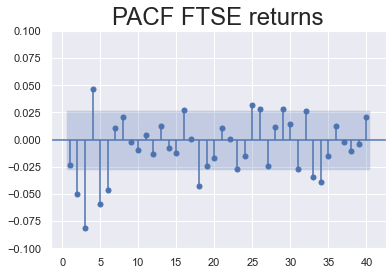

In [24]:
sgt.plot_pacf(df.returns, alpha = 0.05, lags = 40, zero = False, method = ('ols'))
plt.ylim(-0.1,0.1)
plt.title('PACF FTSE returns', size=24)
plt.show()

## Normalization  <a name="normalization"></a>

adjust every X_t to X_1 (the benchmark)

In [42]:
# set a benchmark 
benchmark = df.market_value.iloc[0]
df['norm'] = df.market_value.div(benchmark).mul(100)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
df

,market_value,returns,norm
date,,,
1994-01-10,3440.58,-0.156704,100.000000
1994-01-11,3413.77,-0.779229,99.220771
1994-01-12,3372.02,-1.222988,98.007313
1994-01-13,3360.01,-0.356166,97.658244
1994-01-14,3400.56,1.206842,98.836824
...,...,...,...
2013-04-01,6411.74,0.000000,186.356370
2013-04-02,6490.66,1.230867,188.650169
2013-04-03,6420.28,-1.084327,186.604584


In [44]:
sts.adfuller(df.norm)

(-1.892871013267235,
 0.3354222074330072,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

### Normalizing returns

In [45]:
benchmark = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(benchmark).mul(100)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
sts.adfuller(df.norm_ret)

(-12.77026571949721,
 7.798058336039225e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

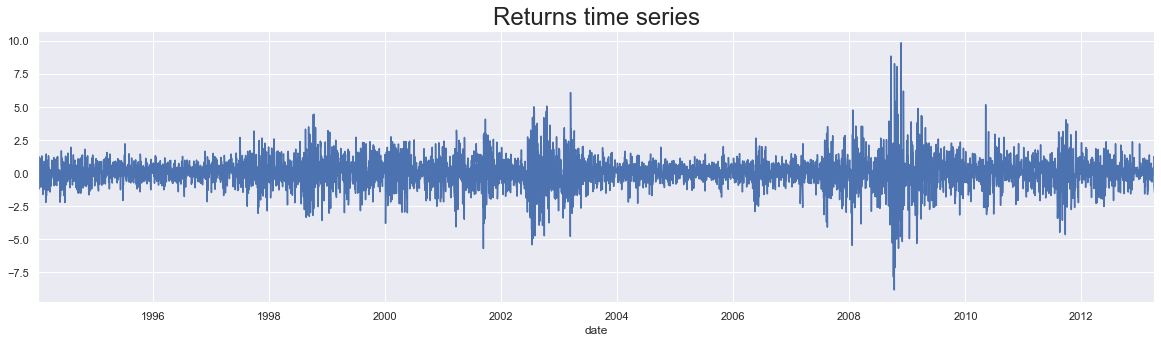

In [47]:
df.returns.plot(figsize=(20,5))
plt.title('Returns time series', size = 24)
plt.show()

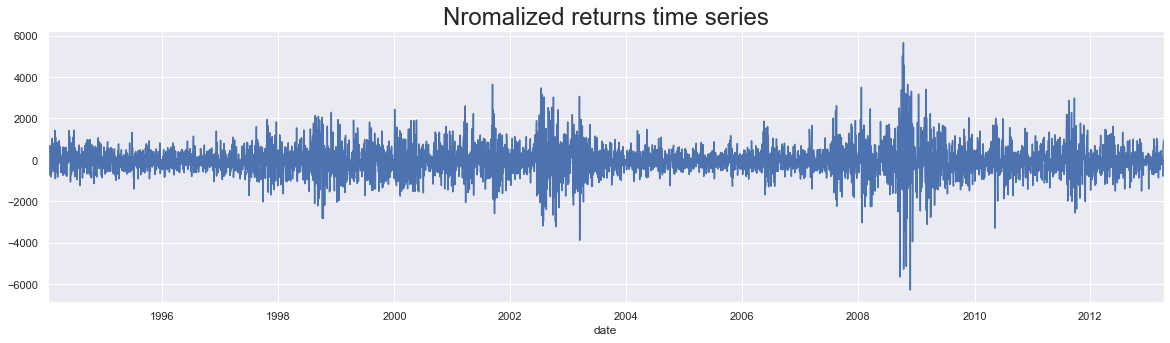

In [48]:
df.norm_ret.plot(figsize=(20,5))
plt.title('Normalized returns time series', size = 24)
plt.show()

In [153]:
# test to compare two models

def LLR_test(mod_1, mod_2, DF=1): # degrees of freedom
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = 2 * (L2-L1)              # test statistic
    p = chi2.sf(LR, DF).round(3)  # p value
    return p

# Models <a name="models"></a>

## Autoregressive Model <a name="AR"></a>

In [32]:
# AR(1) model

model_ar_1 = ARIMA(df.returns, order = (1,0,0))
results_ar_1 = model_ar_1.fit()
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Mon, 10 Oct 2022   AIC                          15865.497
Time:                        11:17:14   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model_ar_2 = ARIMA(df.returns, order = (2,0,0))
res_ar_2 = model_ar_2.fit()
print(res_ar_2.summary())
print('LLR test: '+str(LLR_test(model_ar_1, model_ar_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.456
Date:                Mon, 10 Oct 2022   AIC                          15854.911
Time:                        11:17:30   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.233      -0.012       0.050
ar.L1         -0.0242      0.009     -2.799      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.371      0.0

In [34]:
model_ar_3 = ARIMA(df.returns, order = (3,0,0))
res_ar_3 = model_ar_3.fit()
print(res_ar_3.summary())
print('LLR test: '+str(LLR_test(model_ar_2, model_ar_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7906.738
Date:                Mon, 10 Oct 2022   AIC                          15823.477
Time:                        11:17:38   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.272      0.203      -0.010       0.048
ar.L1         -0.0283      0.009     -3.199      0.001      -0.046      -0.011
ar.L2         -0.0521      0.008     -6.684      0.0

In [35]:
model_ar_4 = ARIMA(df.returns, order = (4,0,0))
res_ar_4 = model_ar_4.fit()
print(res_ar_4.summary())
print('LLR test: '+str(LLR_test(model_ar_3, model_ar_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7901.330
Date:                Mon, 10 Oct 2022   AIC                          15814.661
Time:                        11:17:44   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0245      0.009     -2.770      0.006      -0.042      -0.007
ar.L2         -0.0496      0.008     -6.327      0.0

In [36]:
model_ar_5 = ARIMA(df.returns, order = (5,0,0))
res_ar_5 = model_ar_5.fit()
print(res_ar_5.summary())
print('LLR test: '+str(LLR_test(model_ar_4, model_ar_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7892.390
Date:                Mon, 10 Oct 2022   AIC                          15798.779
Time:                        11:18:13   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.273      0.203      -0.010       0.048
ar.L1         -0.0217      0.009     -2.396      0.017      -0.040      -0.004
ar.L2         -0.0544      0.008     -6.826      0.0

In [39]:
model_ar_6 = ARIMA(df.returns, order = (6,0,0))
res_ar_6 = model_ar_6.fit()
print(res_ar_6.summary())
print('LLR test: '+str(LLR_test(model_ar_5, model_ar_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7886.945
Date:                Mon, 10 Oct 2022   AIC                          15789.890
Time:                        11:19:26   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.324      0.186      -0.009       0.047
ar.L1         -0.0245      0.009     -2.640      0.008      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.505      0.0

In [40]:
model_ar_7 = ARIMA(df.returns, order = (7,0,0))
res_ar_7 = model_ar_7.fit()
print(res_ar_7.summary())
print('LLR test: '+str(LLR_test(model_ar_6, model_ar_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7886.647
Date:                Mon, 10 Oct 2022   AIC                          15791.294
Time:                        11:19:45   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.304      0.192      -0.010       0.047
ar.L1         -0.0240      0.009     -2.579      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.375      0.0

##### It looks like model_6 is better then model_7! 

##### I also fitted the model on the normalized returns but turns out Normalizing does NOT affect the model selection

## Residuals study  <a name="residuals"></a>

In [58]:
model_7 = ARIMA(df.market_value, order = (7,0,0))
res_7 = model_7.fit()
print(res_ar_7.summary())

                               SARIMAX Results                                
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -40308.642
Date:                Mon, 10 Oct 2022   AIC                          80635.285
Time:                        11:58:18   BIC                          80693.975
Sample:                    01-10-1994   HQIC                         80655.851
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731      9.262     -1.293      0.196     -30.126       6.179
ar.L1         -0.0240      0.009     -2.577      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.370      0.0

In [59]:
df['res_price'] = res_7.resid

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
df.res_price.mean()

0.35227857942177354

In [62]:
df.res_price.var()
# high variance (AR perform poorly with non stationary data)

4010.3580586708536

In [63]:
sts.adfuller(df.res_price)
# errors are stationary

(-75.94771894946702,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 54832.16530984734)

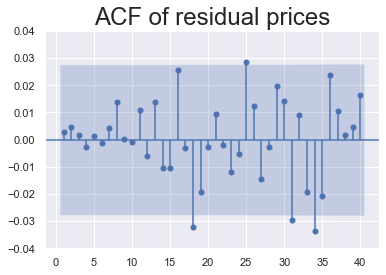

In [65]:
# to make sure errors are random, see the acf
sgt.plot_acf(df.res_price, lags = 40, zero = False)
plt.ylim(-0.04,0.04)
plt.title('ACF of residual prices', size=24)
plt.show()
# good, it's the characteristic od white noies, although it looks like there could be a better predition

<AxesSubplot:xlabel='date'>

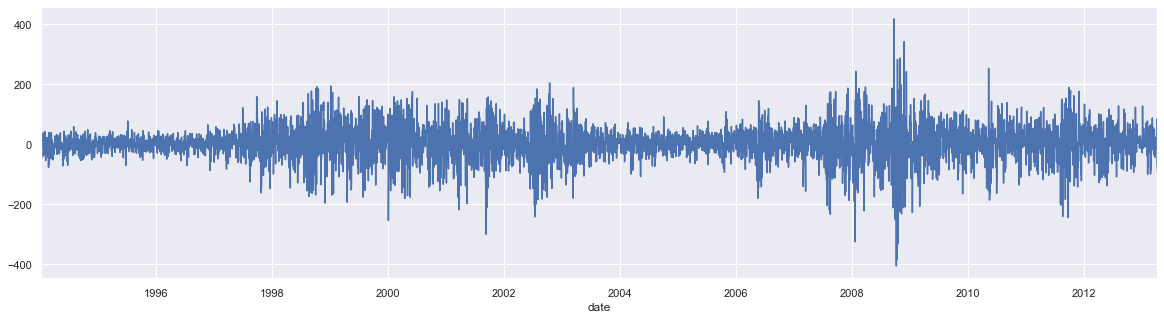

In [66]:
df.res_price[1:].plot(figsize=(20,5))

same with residuals of return

In [80]:
model_ar_6 = ARIMA(df.returns, order = (6,0,0))
res_ar_6 = model_ar_6.fit()
df['res_return'] = res_ar_6.resid

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
df.res_return.mean()

-4.8530419394304825e-05

In [82]:
df.res_return.var()

1.3559802128715168

In [83]:
sts.adfuller(df.res_return)
# errors are stationary

(-70.78411835673874,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.570807333197)

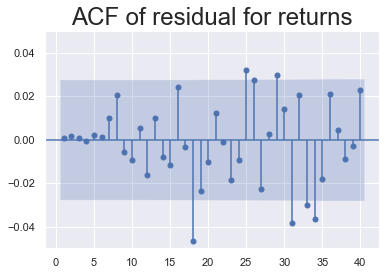

In [87]:
# to make sure errors are random, see the acf
sgt.plot_acf(df.res_return, lags = 40, zero = False)
plt.ylim(-0.05,0.05)
plt.title('ACF of residual for returns', size=24)
plt.show()
# good, it still looks like there could be a better preditor

<AxesSubplot:xlabel='date'>

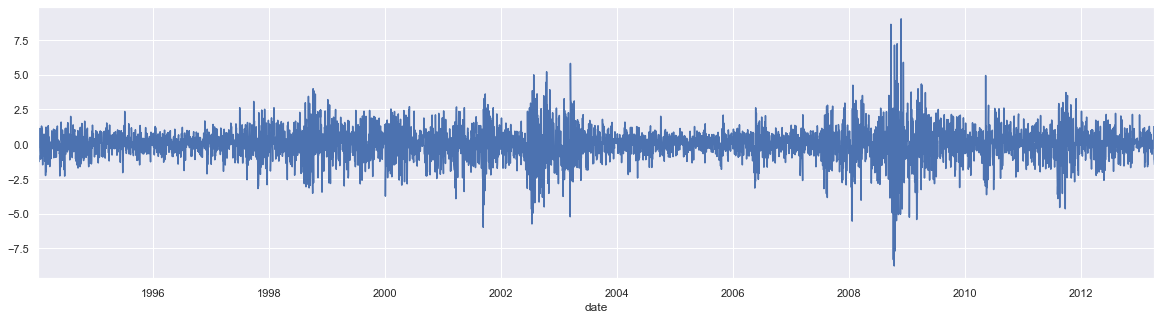

In [85]:
df.res_return[1:].plot(figsize=(20,5))

## Moving average  <a name="ma"></a>

In [95]:
df['returns'] = df.market_value.pct_change(1).mul(100)
# instead of deleting the first element, we'll fit the model on df[1:]

In [97]:
mod_ret_ma_1 = ARIMA(df.returns[1:], order = (0,0,1))
res_ret_ma_1 = mod_ret_ma_1.fit()
res_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7928.501
Date:                Mon, 10 Oct 2022   AIC                          15863.003
Time:                        15:05:34   BIC                          15882.566
Sample:                    01-11-1994   HQIC                         15869.858
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.148      0.251      -0.013       0.051
ma.L1         -0.0258      0.009     -3.021      0.003      -0.042      -0.009
sigma2         1.3792      0.014     99.965      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7846.66
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Higher-lag MA model

In [100]:
mod_ret_ma_2 = ARIMA(df.returns[1:], order = (0,0,2))
res_ret_ma_2 = mod_ret_ma_2.fit()
print(res_ret_ma_2.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_1,mod_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7921.760
Date:                Mon, 10 Oct 2022   AIC                          15851.521
Time:                        15:09:28   BIC                          15877.605
Sample:                    01-11-1994   HQIC                         15860.661
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.016      1.207      0.227      -0.012       0.049
ma.L1         -0.0327      0.009     -3.764      0.000      -0.050      -0.016
ma.L2         -0.0503      0.008     -6.421      0.0

In [101]:
mod_ret_ma_3 = ARIMA(df.returns[1:], order = (0,0,3))
res_ret_ma_3 = mod_ret_ma_3.fit()
print(res_ret_ma_3.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_2,mod_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7903.214
Date:                Mon, 10 Oct 2022   AIC                          15816.429
Time:                        15:10:12   BIC                          15849.034
Sample:                    01-11-1994   HQIC                         15827.854
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.299      0.194      -0.010       0.048
ma.L1         -0.0203      0.009     -2.336      0.019      -0.037      -0.003
ma.L2         -0.0557      0.008     -7.035      0.0

In [103]:
mod_ret_ma_4 = ARIMA(df.returns[1:], order = (0,0,4))
res_ret_ma_4 = mod_ret_ma_4.fit()
print(res_ret_ma_4.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_3,mod_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7897.656
Date:                Mon, 10 Oct 2022   AIC                          15807.312
Time:                        15:11:20   BIC                          15846.438
Sample:                    01-11-1994   HQIC                         15821.022
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.239      0.215      -0.011       0.049
ma.L1         -0.0203      0.009     -2.242      0.025      -0.038      -0.003
ma.L2         -0.0551      0.008     -6.840      0.0

In [105]:
mod_ret_ma_5 = ARIMA(df.returns[1:], order = (0,0,5))
res_ret_ma_5 = mod_ret_ma_5.fit()
print(res_ret_ma_5.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_4,mod_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7891.710
Date:                Mon, 10 Oct 2022   AIC                          15797.421
Time:                        15:11:50   BIC                          15843.068
Sample:                    01-11-1994   HQIC                         15813.416
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.285      0.199      -0.010       0.048
ma.L1         -0.0262      0.009     -2.841      0.004      -0.044      -0.008
ma.L2         -0.0498      0.008     -6.152      0.0

In [106]:
mod_ret_ma_6 = ARIMA(df.returns[1:], order = (0,0,6))
res_ret_ma_6 = mod_ret_ma_6.fit()
print(res_ret_ma_6.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_5,mod_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7888.117
Date:                Mon, 10 Oct 2022   AIC                          15792.234
Time:                        15:12:14   BIC                          15844.402
Sample:                    01-11-1994   HQIC                         15810.515
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.014      1.321      0.187      -0.009       0.047
ma.L1         -0.0237      0.009     -2.564      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.987      0.0

In [107]:
mod_ret_ma_7 = ARIMA(df.returns[1:], order = (0,0,7))
res_ret_ma_7 = mod_ret_ma_7.fit()
print(res_ret_ma_7.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_6,mod_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7887.940
Date:                Mon, 10 Oct 2022   AIC                          15793.880
Time:                        15:12:44   BIC                          15852.569
Sample:                    01-11-1994   HQIC                         15814.445
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.306      0.192      -0.010       0.047
ma.L1         -0.0247      0.009     -2.648      0.008      -0.043      -0.006
ma.L2         -0.0489      0.008     -6.005      0.0

In [108]:
mod_ret_ma_8 = ARIMA(df.returns[1:], order = (0,0,8))
res_ret_ma_8 = mod_ret_ma_8.fit()
print(res_ret_ma_8.summary())
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_7,mod_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7884.499
Date:                Mon, 10 Oct 2022   AIC                          15788.999
Time:                        15:13:10   BIC                          15854.208
Sample:                    01-11-1994   HQIC                         15811.849
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.256      0.209      -0.011       0.049
ma.L1         -0.0239      0.009     -2.530      0.011      -0.042      -0.005
ma.L2         -0.0496      0.008     -6.058      0.0

In [112]:
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_6,mod_ret_ma_8, DF = 2)))

# DF = 2!! abbiamo 2 gradi tra 8 e 6


LLR test p-value:0.027


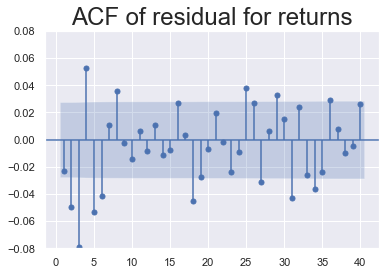

In [117]:
sgt.plot_acf(df.returns[1:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of residual for returns', size=24)
plt.show()

Il grafico ACF spiega quel che è successo: i primi lag hanno significance alta e sono inclusi nel modello. Il settimo è quello bassino in alto e non contribuisce molto. Però andando all'ottavo si vede che l'autocorrelazione aumenta di nuovo. Ci fermiamo qua perchè si vede che i succettivi sono nella soglia di significance.

## MA residuals

In [119]:
df['res_ret_ma_8']= res_ret_ma_8.resid[1:]

In [123]:
round(df.res_ret_ma_8.mean(),3)

0.0

In [124]:
round(df.res_ret_ma_8.var(),3)

1.356

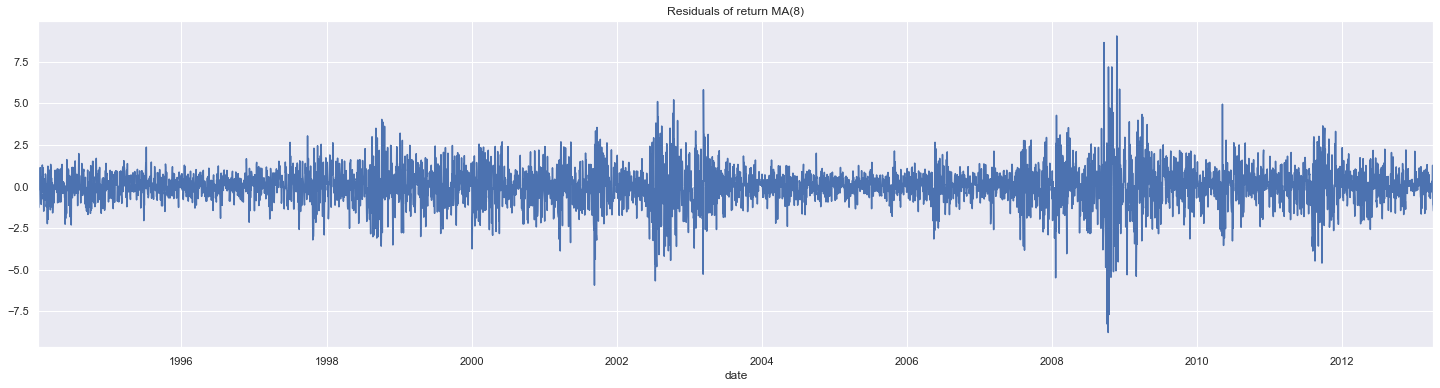

In [132]:
df.res_ret_ma_8[1:].plot(figsize=(25,6))
plt.title('Residuals of return MA(8)')
plt.show()

In [133]:
# DF test for stationarity to see if it white noise
sts.adfuller(df.res_ret_ma_8[2:])

(-70.84105756362975,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 15681.854152216543)

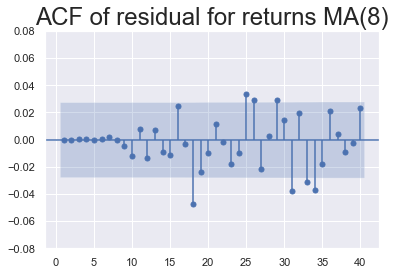

In [134]:
# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_ret_ma_8[2:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of residual for returns MA(8)', size=24)
plt.show()

### same with MA(6) to see which one is better

In [135]:
df['res_ret_ma_6']= res_ret_ma_6.resid[1:]

In [136]:
round(df.res_ret_ma_6.mean(),3)

0.0

In [137]:
round(df.res_ret_ma_6.var(),3)

1.358

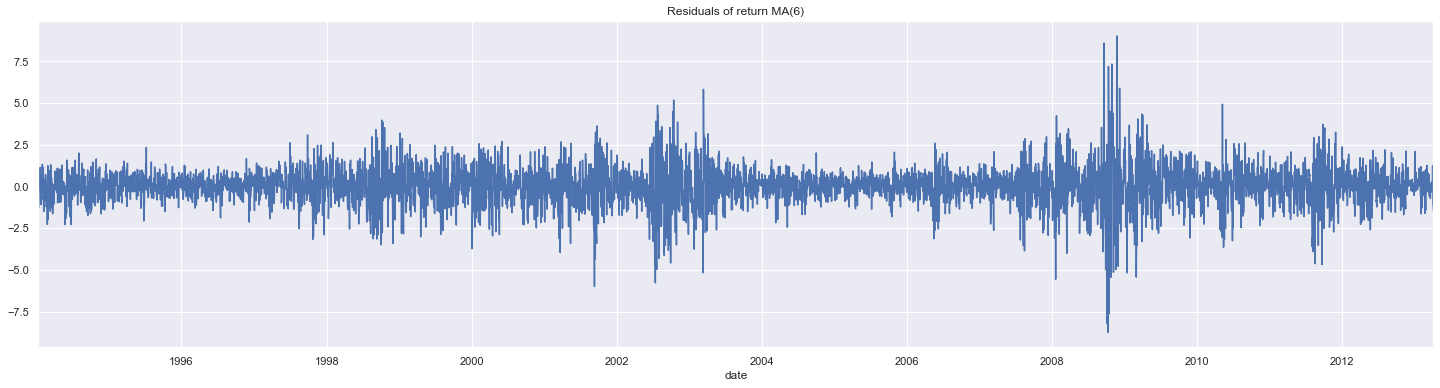

In [138]:
df.res_ret_ma_6[1:].plot(figsize=(25,6))
plt.title('Residuals of return MA(6)')
plt.show()

In [139]:
# DF test for stationarity to see if it white noise
sts.adfuller(df.res_ret_ma_6[2:])

(-70.84510110105631,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 15688.92362027201)

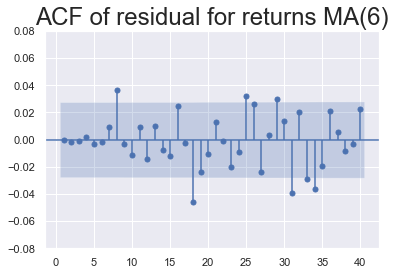

In [140]:
# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_ret_ma_6[2:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of residual for returns MA(6)', size=24)
plt.show()

## MA model with Nomalized values

In [142]:
bench_ret = df.returns.iloc[1]
df['norm_ret']= df.returns.div(bench_ret).mul(100)

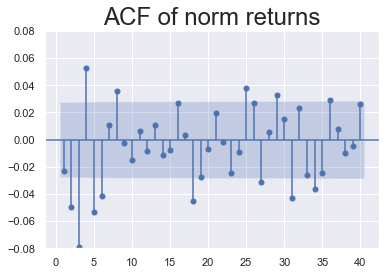

In [143]:
sgt.plot_acf(df.norm_ret[2:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of norm returns', size=24)
plt.show()

looks like MA(6) or MA(8) will do the job again

In [145]:
mod_norm_ret_ma_1 = ARIMA(df.norm_ret[1:], order = (0,0,1))
res_norm_ret_ma_1 = mod_norm_ret_ma_1.fit()
print(res_norm_ret_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:               norm_ret   No. Observations:                 5019
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -32293.841
Date:                Mon, 10 Oct 2022   AIC                          64593.682
Time:                        15:31:02   BIC                          64613.245
Sample:                    01-11-1994   HQIC                         64600.537
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4123      2.102     -1.148      0.251      -6.532       1.708
ma.L1         -0.0258      0.009     -3.021      0.003      -0.042      -0.009
sigma2      2.272e+04    227.245     99.961      0.0

In [146]:
mod_norm_ret_ma_8 = ARIMA(df.norm_ret[1:], order = (0,0,8))
res_norm_ret_ma_8 = mod_norm_ret_ma_8.fit()
print(res_norm_ret_ma_8.summary())

                               SARIMAX Results                                
Dep. Variable:               norm_ret   No. Observations:                 5019
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -32249.856
Date:                Mon, 10 Oct 2022   AIC                          64519.712
Time:                        15:31:19   BIC                          64584.922
Sample:                    01-11-1994   HQIC                         64542.562
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4123      1.943     -1.242      0.214      -6.220       1.395
ma.L1         -0.0239      0.009     -2.521      0.012      -0.042      -0.005
ma.L2         -0.0496      0.008     -6.035      0.0

In [147]:
# residuals for MA(8)
df['res_norm_ret_ma_8']= res_norm_ret_ma_8.resid[1:]
round(df.res_norm_ret_ma_8.mean(),3)

-0.035

In [148]:
round(df.res_norm_ret_ma_8.var(),3)

22326.362

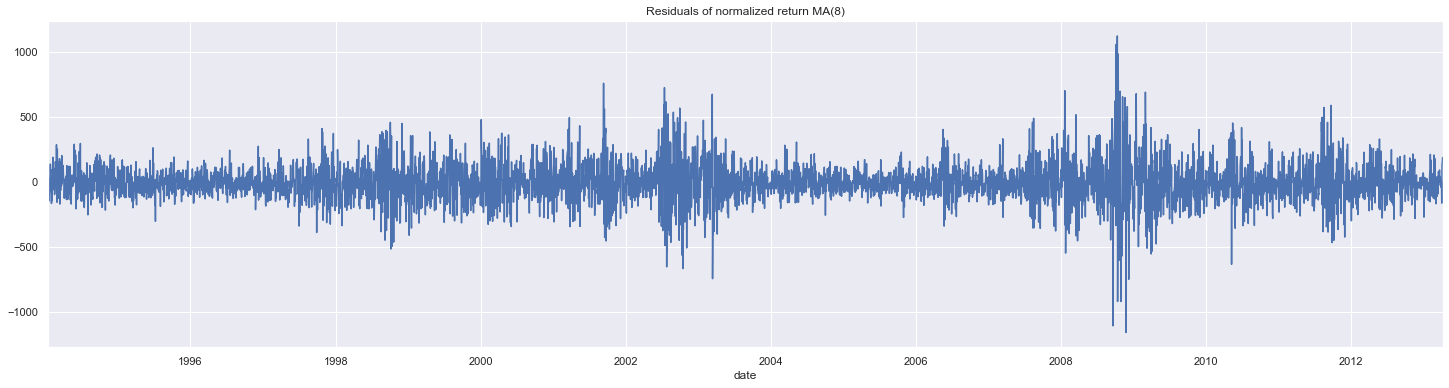

In [150]:
df.res_norm_ret_ma_8[1:].plot(figsize=(25,6))
plt.title('Residuals of normalized return MA(8)')
plt.show()

In [151]:
# DF test for stationarity to see if it white noise
sts.adfuller(df.res_norm_ret_ma_8[2:])

(-70.84109300312839,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 64082.419426082146)

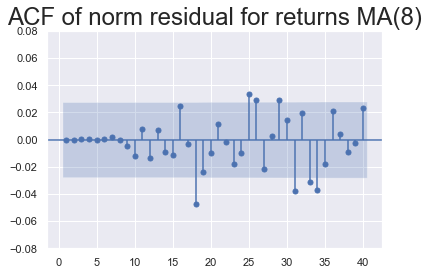

In [152]:
# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_norm_ret_ma_8[2:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of norm residual for returns MA(8)', size=24)
plt.show()

## MA for non stationary data <a name="MAns"></a>

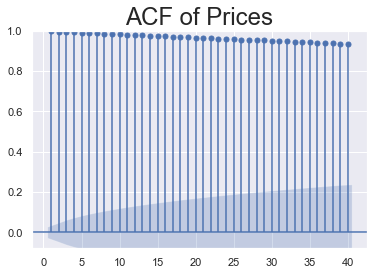

In [155]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.ylim(-0.08,1)
plt.title('ACF of Prices', size=24)
plt.show()

The ACF suggests that every lag is significant, thus we need a MA(infinite) model to fit the data.... NO MA is good estimator for prices

In [158]:
mod_ma_1 = ARIMA(df.market_value, order = (0,0,1))
res_ma_1 = mod_ma_1.fit()
print(res_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38620.627
Date:                Mon, 10 Oct 2022   AIC                          77247.253
Time:                        15:39:37   BIC                          77266.817
Sample:                    01-10-1994   HQIC                         77254.109
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.9579     15.768    322.813      0.000    5059.054    5120.862
ma.L1          0.9573      0.004    232.394      0.000       0.949       0.965
sigma2      2.804e+05   8087.094     34.675      0.0

Il coefficiente di L1 è 0.957.... sembra molto un AR model 

## ARMA models <a name="arma"></a>

In [159]:
mod_ret_ar_1_ma_1 = ARIMA(df.returns[1:], order = (1,0,1))
res_ret_ar_1_ma_1 = mod_ret_ar_1_ma_1.fit()
print(res_ret_ar_1_ma_1.summary())

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7915.406
Date:                Mon, 10 Oct 2022   AIC                          15838.812
Time:                        17:44:20   BIC                          15864.896
Sample:                    01-11-1994   HQIC                         15847.952
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.292      0.196      -0.010       0.048
ar.L1          0.7647      0.045     16.976      0.000       0.676       0.853
ma.L1         -0.8139      0.040    -20.164      0.0

In [160]:
mod_ret_ar_1 = ARIMA(df.returns[1:], order = (1,0,0))
res_ret_ar_1 = mod_ret_ar_1.fit()
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ar_1,mod_ret_ar_1_ma_1)))

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



LLR test p-value:0.0


In [162]:
mod_ret_ma_1 = ARIMA(df.returns[1:], order = (0,0,1))
res_ret_ma_1 = mod_ret_ma_1.fit()
print('\nLLR test p-value:'+ str(LLR_test(mod_ret_ma_1,mod_ret_ar_1_ma_1)))


LLR test p-value:0.0


### Higher lags

In [164]:
mod_ret_ar_8_ma_6 = ARIMA(df.returns[1:], order = (8,0,6))
res_ret_ar_8_ma_6 = mod_ret_ar_8_ma_6.fit()
print(res_ret_ar_8_ma_6.summary())
# fa schifo!

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(8, 0, 6)   Log Likelihood               -7882.578
Date:                Mon, 10 Oct 2022   AIC                          15797.157
Time:                        17:55:18   BIC                          15901.492
Sample:                    01-11-1994   HQIC                         15833.718
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.014      1.322      0.186      -0.009       0.047
ar.L1         -0.1195      4.935     -0.024      0.981      -9.792       9.553
ar.L2         -0.3999      2.510     -0.159      0.8

In [165]:
mod_ret_ar_3_ma_3 = ARIMA(df.returns[1:], order = (3,0,3))
res_ret_ar_3_ma_3 = mod_ret_ar_3_ma_3.fit()
print(res_ret_ar_3_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7892.414
Date:                Mon, 10 Oct 2022   AIC                          15800.829
Time:                        17:56:01   BIC                          15852.997
Sample:                    01-11-1994   HQIC                         15819.109
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.285      0.199      -0.010       0.048
ar.L1         -0.1884      0.068     -2.782      0.005      -0.321      -0.056
ar.L2         -0.2929      0.054     -5.375      0.0

In [166]:
mod_ret_ar_3_ma_2 = ARIMA(df.returns[1:], order = (3,0,2))
res_ret_ar_3_ma_2 = mod_ret_ar_3_ma_2.fit()
print(res_ret_ar_3_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7894.627
Date:                Mon, 10 Oct 2022   AIC                          15803.254
Time:                        17:57:43   BIC                          15848.901
Sample:                    01-11-1994   HQIC                         15819.250
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.016      1.216      0.224      -0.012       0.049
ar.L1         -0.6780      0.055    -12.304      0.000      -0.786      -0.570
ar.L2         -0.5081      0.063     -8.033      0.0

In [167]:
mod_ret_ar_2_ma_3 = ARIMA(df.returns[1:], order = (2,0,3))
res_ret_ar_2_ma_3 = mod_ret_ar_2_ma_3.fit()
print(res_ret_ar_2_ma_3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7894.467
Date:                Mon, 10 Oct 2022   AIC                          15802.935
Time:                        17:58:31   BIC                          15848.581
Sample:                    01-11-1994   HQIC                         15818.930
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.228      0.219      -0.011       0.049
ar.L1         -0.5600      0.057     -9.772      0.000      -0.672      -0.448
ar.L2         -0.4168      0.066     -6.362      0.0

 ### Analyse residuals of ARMA(3,2)

In [171]:
df['res_ret_ar_3_ma_2'] = res_ret_ar_3_ma_2.resid[1:]

In [172]:
round(df.res_ret_ar_3_ma_2.mean(),3)

0.0

In [173]:
round(df.res_ret_ar_3_ma_2.var(),3)

1.361

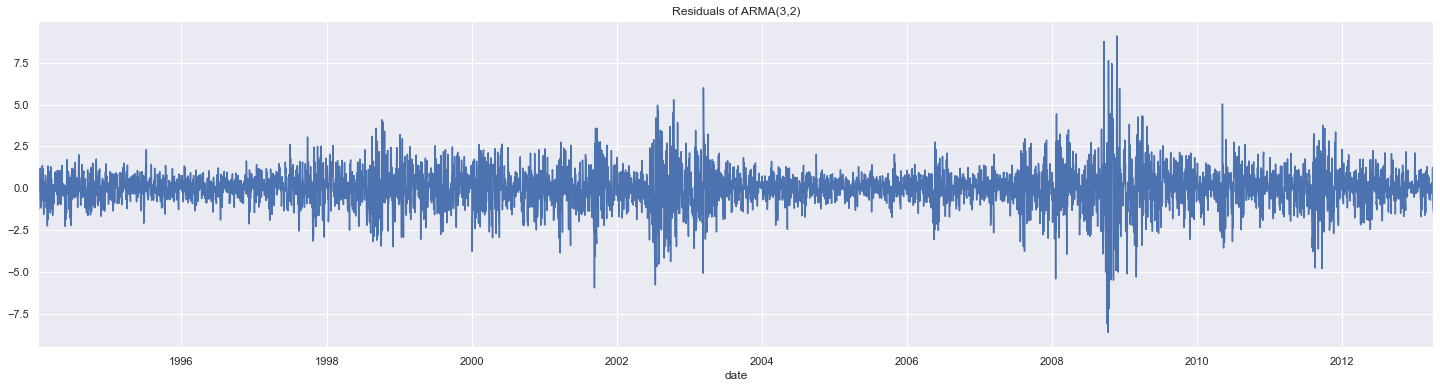

In [174]:
df.res_ret_ar_3_ma_2[1:].plot(figsize=(25,6))
plt.title('Residuals of ARMA(3,2)')
plt.show()

In [175]:
# DF test for stationarity to see if it white noise
sts.adfuller(df.res_ret_ar_3_ma_2[2:])

(-12.802676722715654,
 6.70202743217137e-24,
 32,
 4985,
 {'1%': -3.4316624715142177,
  '5%': -2.862119970102166,
  '10%': -2.5670787188546584},
 15689.104899961174)

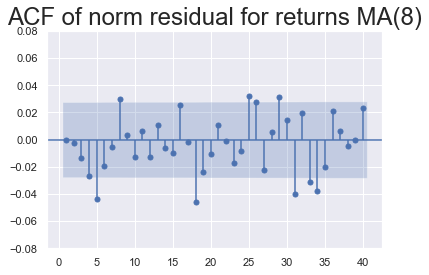

In [176]:
# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of norm residual for returns MA(8)', size=24)
plt.show()

there are more significant lags than the AR and MA models... maybe whe should consider an ARMA(5,q)

In [177]:
mod_ret_ar_5_ma_5 = ARIMA(df.returns[1:], order = (5,0,5))
res_ret_ar_5_ma_5 = mod_ret_ar_5_ma_5.fit()
print(res_ret_ar_5_ma_5.summary())

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7881.483
Date:                Tue, 11 Oct 2022   AIC                          15786.966
Time:                        11:38:57   BIC                          15865.218
Sample:                    01-11-1994   HQIC                         15814.387
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.015      1.286      0.199      -0.010       0.048
ar.L1         -0.1287      0.105     -1.224      0.221      -0.335       0.077
ar.L2         -0.5797      0.080     -7.262      0.0

only 3 coefficients are significant.. taking both returns and residuals 5 periods ago is redundant... We should focus on ARMA(5,1) or ARMA(1,5). They have the same Degrees of freedom, so we cannot applt the LLR test. We'll compare the log likelihood and the AIC.

In [178]:
mod_ret_ar_1_ma_5 = ARIMA(df.returns[1:], order = (1,0,5))
res_ret_ar_1_ma_5 = mod_ret_ar_1_ma_5.fit()
print(res_ret_ar_1_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7889.868
Date:                Tue, 11 Oct 2022   AIC                          15795.735
Time:                        11:43:03   BIC                          15847.903
Sample:                    01-11-1994   HQIC                         15814.016
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.301      0.193      -0.010       0.048
ar.L1          0.3217      0.133      2.412      0.016       0.060       0.583
ma.L1         -0.3467      0.134     -2.591      0.0

In [179]:
mod_ret_ar_5_ma_1 = ARIMA(df.returns[1:], order = (5,0,1))
res_ret_ar_5_ma_1 = mod_ret_ar_5_ma_1.fit()
print(res_ret_ar_5_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -7888.206
Date:                Tue, 11 Oct 2022   AIC                          15792.412
Time:                        11:43:25   BIC                          15844.580
Sample:                    01-11-1994   HQIC                         15810.693
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.304      0.192      -0.010       0.047
ar.L1          0.3446      0.106      3.265      0.001       0.138       0.551
ar.L2         -0.0458      0.009     -4.855      0.0

In [183]:
print('ARMA(1,5) \t LL = ', res_ret_ar_1_ma_5.llf,'\n\t\t AIC= ', res_ret_ar_1_ma_5.aic)
print('ARMA(5,1) \t LL = ', res_ret_ar_5_ma_1.llf,'\n\t\t AIC= ', res_ret_ar_5_ma_1.aic)

ARMA(1,5) 	 LL =  -7889.8676367808675 
		 AIC=  15795.735273561735
ARMA(5,1) 	 LL =  -7888.206004167805 
		 AIC=  15792.41200833561


ARMA(5,1) has higher LL but lower information cryeria --> best choice. Is it also better than the ARMA(3,2)?

In [184]:
print('ARMA(3,2) \t LL = ', res_ret_ar_3_ma_2.llf,'\n\t\t AIC= ', res_ret_ar_3_ma_2.aic)

ARMA(3,2) 	 LL =  -7894.627104090544 
		 AIC=  15803.254208181088


ARMA(5,1) wins! Let's examine the residuals

In [185]:
df['res_ret_ar_5_ma_1'] = res_ret_ar_5_ma_1.resid[1:]

In [186]:
round(df.res_ret_ar_5_ma_1.mean(),3)

0.0

In [187]:
round(df.res_ret_ar_5_ma_1.var(),3)

1.358

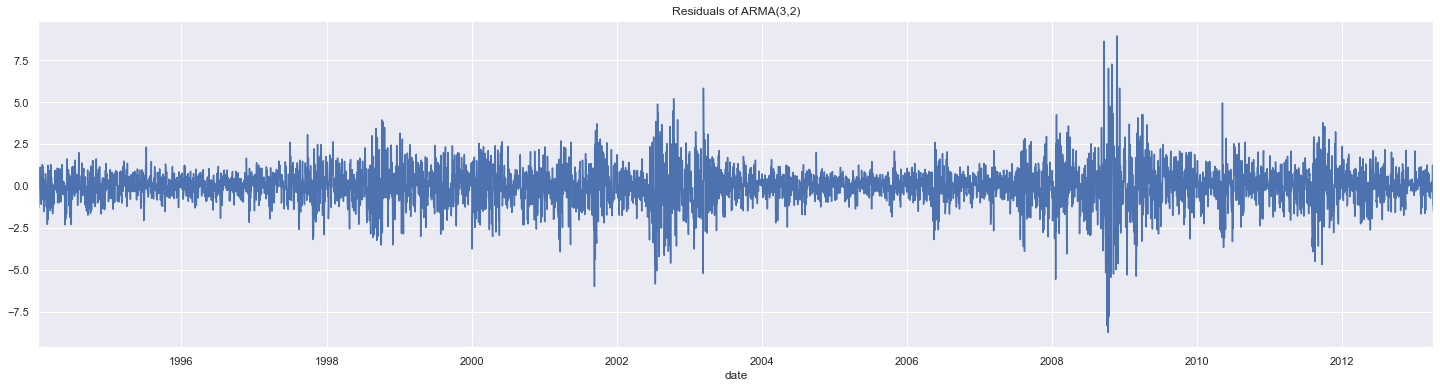

In [188]:
df.res_ret_ar_5_ma_1[1:].plot(figsize=(25,6))
plt.title('Residuals of ARMA(3,2)')
plt.show()

In [191]:
# DF test for stationarity to see if it white noise
sts.adfuller(df.res_ret_ar_5_ma_1[2:])

(-70.89626532348635,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 15689.127014243053)

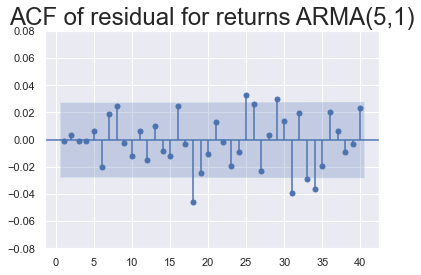

In [190]:
# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_ret_ar_5_ma_1[2:], lags = 40, zero = False)
plt.ylim(-0.08,0.08)
plt.title('ACF of residual for returns ARMA(5,1)', size=24)
plt.show()

 no lag is significant before the 18!

## ARIMA models <a name="ARIMA"></a>

In [198]:
mod_ar_1_i_1_ma_1 = ARIMA(df.market_value, order = (1,1,1))
res_ar_1_i_1_ma_1 = mod_ar_1_i_1_ma_1.fit()
print(res_ar_1_i_1_ma_1.summary())

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27599.000
Date:                Tue, 11 Oct 2022   AIC                          55203.999
Time:                        14:51:26   BIC                          55223.562
Sample:                    01-10-1994   HQIC                         55210.854
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7466      0.059     12.692      0.000       0.631       0.862
ma.L1         -0.7925      0.053    -14.970      0.000      -0.896      -0.689
sigma2      3497.8883     40.914     85.494      0.0

mean: 1.377

variance: 5854.599


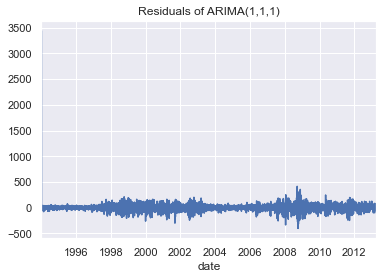

In [199]:
df['res_ar_1_i_1_ma_1'] = res_ar_1_i_1_ma_1.resid

print('mean: '+str(round(df.res_ar_1_i_1_ma_1.mean(),3)))

print('\nvariance: '+str(round(df.res_ar_1_i_1_ma_1.var(),3)))

df.res_ar_1_i_1_ma_1.plot()
plt.title('Residuals of ARIMA(1,1,1)')
plt.show()

DF test:  (-25.58693455194436, 0.0, 7, 5012, {'1%': -3.431655397510801, '5%': -2.862116844845668, '10%': -2.567077055158601}, 54849.24900441414)


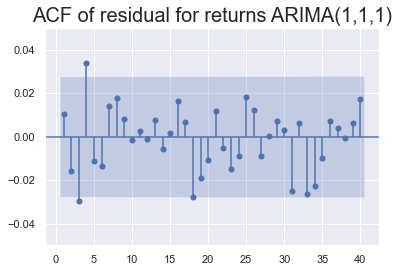

In [202]:
# DF test for stationarity to see if it white noise
print('DF test: ',sts.adfuller(df.res_ar_1_i_1_ma_1))

# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_ar_1_i_1_ma_1, lags = 40, zero = False)
plt.ylim(-0.05,0.05)
plt.title('ACF of residual for returns ARIMA(1,1,1)', size=20)
plt.show()

In [206]:
mod_ar_1_i_1_ma_2 = ARIMA(df.market_value, order = (1,1,2))
res_ar_1_i_1_ma_2 = mod_ar_1_i_1_ma_2.fit()
mod_ar_1_i_1_ma_3 = ARIMA(df.market_value, order = (1,1,3))
res_ar_1_i_1_ma_3 = mod_ar_1_i_1_ma_3.fit()
mod_ar_2_i_1_ma_1 = ARIMA(df.market_value, order = (2,1,1))
res_ar_2_i_1_ma_1 = mod_ar_2_i_1_ma_1.fit()
mod_ar_3_i_1_ma_1 = ARIMA(df.market_value, order = (3,1,1))
res_ar_3_i_1_ma_1 = mod_ar_3_i_1_ma_1.fit()
mod_ar_3_i_1_ma_2 = ARIMA(df.market_value, order = (3,1,2))
res_ar_3_i_1_ma_2 = mod_ar_3_i_1_ma_2.fit()


In [209]:
print('ARIMA(1,1,1) \t LL = ', res_ar_1_i_1_ma_1.llf,
      '\n\t\t AIC= ', res_ar_1_i_1_ma_1.aic)

print('ARIMA(1,1,2) \t LL = ', res_ar_1_i_1_ma_2.llf,
      '\n\t\t AIC= ', res_ar_1_i_1_ma_2.aic)

print('ARIMA(1,1,3) \t LL = ', res_ar_1_i_1_ma_3.llf,
      '\n\t\t AIC= ', res_ar_1_i_1_ma_3.aic)

print('ARIMA(2,1,1) \t LL = ', res_ar_2_i_1_ma_1.llf,
      '\n\t\t AIC= ', res_ar_2_i_1_ma_1.aic)

print('ARIMA(3,1,1) \t LL = ', res_ar_3_i_1_ma_1.llf,
      '\n\t\t AIC= ', res_ar_3_i_1_ma_1.aic)

print('ARIMA(3,1,2) \t LL = ', res_ar_3_i_1_ma_2.llf,
      '\n\t\t AIC= ', res_ar_3_i_1_ma_2.aic)



ARIMA(1,1,1) 	 LL =  -27598.999611567204 
		 AIC=  55203.99922313441
ARIMA(1,1,2) 	 LL =  -27595.404099456457 
		 AIC=  55198.80819891291
ARIMA(1,1,3) 	 LL =  -27585.71077371474 
		 AIC=  55181.42154742948
ARIMA(2,1,1) 	 LL =  -27595.127257741646 
		 AIC=  55198.25451548329
ARIMA(3,1,1) 	 LL =  -27587.321660475885 
		 AIC=  55184.64332095177
ARIMA(3,1,2) 	 LL =  -27585.90257992683 
		 AIC=  55183.80515985366


In [211]:
# 1,1,3 is better. we can also do an LLR test:

print('\nLLR test p-value with 112: '+str(LLR_test(mod_ar_1_i_1_ma_2, mod_ar_1_i_1_ma_3)))

print('\nLLR test p-value with 111: '+str(LLR_test(mod_ar_1_i_1_ma_1, mod_ar_1_i_1_ma_3, DF = 2)))



LLR test p-value with 112: 0.0

LLR test p-value with 111: 0.0


mean: 1.336

variance: 5836.216


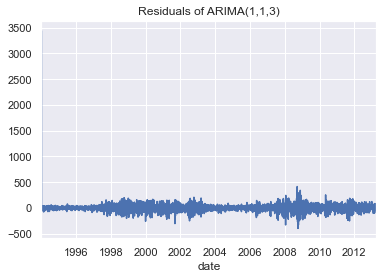

In [212]:
df['res_ar_1_i_1_ma_3'] = res_ar_1_i_1_ma_3.resid

print('mean: '+str(round(df.res_ar_1_i_1_ma_3.mean(),3)))

print('\nvariance: '+str(round(df.res_ar_1_i_1_ma_3.var(),3)))

df.res_ar_1_i_1_ma_3.plot()
plt.title('Residuals of ARIMA(1,1,3)')
plt.show()

DF test:  (-30.959818743035537, 0.0, 5, 5014, {'1%': -3.4316548765428174, '5%': -2.8621166146845334, '10%': -2.5670769326348926}, 54847.25190512495)


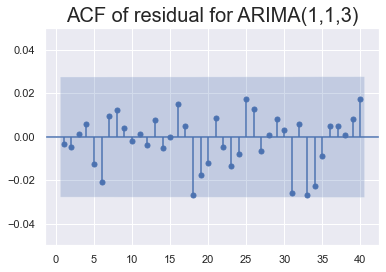

In [214]:
# DF test for stationarity to see if it white noise
print('DF test: ',sts.adfuller(df.res_ar_1_i_1_ma_3))

# ACF: if it is WS all lags should be insignificant
sgt.plot_acf(df.res_ar_1_i_1_ma_3, lags = 40, zero = False)
plt.ylim(-0.05,0.05)
plt.title('ACF of residual for ARIMA(1,1,3)', size=20)
plt.show()

## ARIMAX models <a name="ARIMAX"></a>

In [220]:
# exogenous variable = S&P
mod_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog = df.spx, order = (1,1,1))
res_ar_1_i_1_ma_1_Xspx = mod_ar_1_i_1_ma_1_Xspx.fit()
print(res_ar_1_i_1_ma_1_Xspx.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26693.392
Date:                Tue, 11 Oct 2022   AIC                          53394.784
Time:                        15:42:26   BIC                          53420.869
Sample:                    01-07-1994   HQIC                         53403.925
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.6928      0.035     76.407      0.000       2.624       2.762
ar.L1          0.2571      0.029      8.812      0.000       0.200       0.314
ma.L1         -0.5460      0.025    -21.791      0.0

## SARIMAX <a name="SARIMAX"></a>

In [223]:
mod_sarimax = SARIMAX(df.market_value, 
                      exog = df.spx, 
                      order = (1,0,1),
                     seasonal_order = (2,0,1,5))
res_sarimax = mod_sarimax.fit()
print(res_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.560
Date:                           Tue, 11 Oct 2022   AIC                          53439.121
Time:                                   15:55:07   BIC                          53484.770
Sample:                               01-07-1994   HQIC                         53455.117
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7035      0.035     76.476      0.000       2.634       2.773
ar.L1          0.9999      0.000   2703.785

## AutoRegressive Conditional Heteroskedasticity (ARCH) model <a name="ARCH"></a>

In [225]:
# returns
df['returns'] = df.market_value.pct_change(1)*100

# squared returns
df['sq_returns'] = df.returns.mul(df.returns)

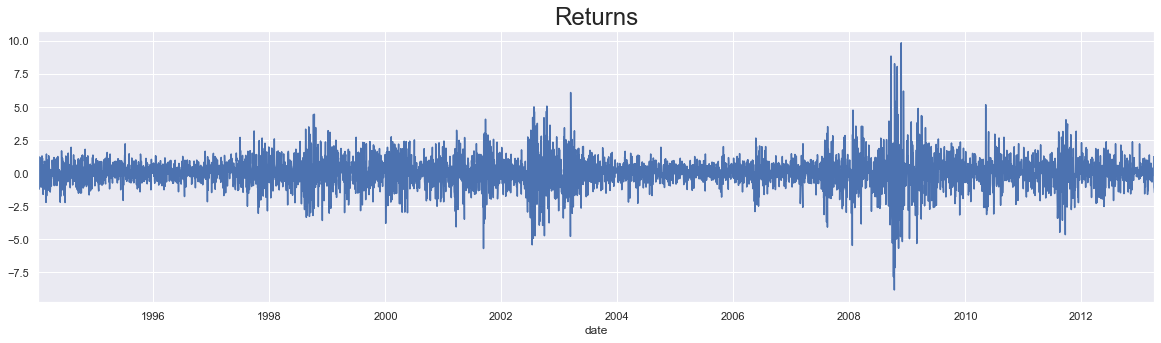

In [228]:
df.returns.plot(figsize = (20,5))
plt.title('Returns', size = 24)
plt.show()

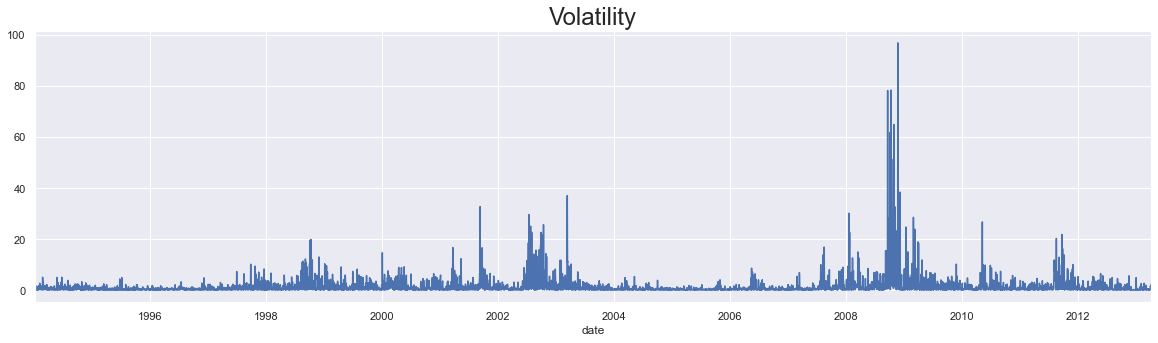

In [230]:
df.sq_returns.plot(figsize = (20,5))
plt.title('Volatility', size = 24)
plt.show()

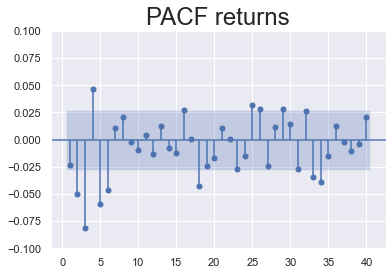

In [232]:
sgt.plot_pacf(df.returns[1:], alpha = 0.05, lags = 40, zero = False, method = ('ols'))
plt.ylim(-0.1,0.1)
plt.title('PACF returns', size=24)
plt.show()

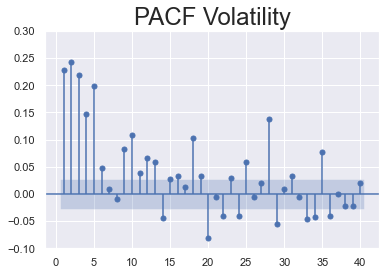

In [237]:
sgt.plot_pacf(df.sq_returns[1:], alpha = 0.05, lags = 40, zero = False, method = ('ols'))
plt.ylim(-0.1,0.3)
plt.title('PACF Volatility', size=24)
plt.show()

high significance suggests there tend to be short-term trendis in variance: High variation is followed by high variation, same for low variation (clustering)

In [239]:
model_arch_1 = arch_model(df.returns[1:])
res_arch_1 = model_arch_1.fit()
res_arch_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6579303469.390623
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2701100877.2298183
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7009.030632045198
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.035835212278
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712887007633
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.418108744094
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7092.271338807877
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879266228052
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6970.088048943886
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6970.0583674757745
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189882
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6970.058366189167
Optimization terminated successfully    (Exit mode 0)
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Oct 12 2022   Df Residuals:                     5019
Time:                        10:41:17   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

In [245]:
model_arch_1 = arch_model(df.returns[1:], 
                          mean = 'constant', # could also set a value or AR
                          vol = 'ARCH', # for the ARCH model
                          p=1) # order
# can also set the distr of the errors as dist = 't', ..
res_arch_1 = model_arch_1.fit(update_freq=5)
res_arch_1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Wed, Oct 12 2022   Df Residuals:                     5019
Time:                        11:01:21   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

In [244]:
model_arch_2 = arch_model(df.returns[1:], 
                          mean = 'constant', 
                          vol = 'ARCH', 
                          p=2) 
res_arch_2 = model_arch_2.fit(update_freq=5)
res_arch_2.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: 8810.02930517937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Wed, Oct 12 2022   Df Residuals:                     5019
Time:                        11:01:17   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

 ## GARCH <a name="GARCH"></a>

In [246]:
model_garch_1_1 = arch_model(df.returns[1:],
                             mean = 'constant',
                             vol = 'GARCH',
                          p=1, q=1)  
res_garch_1_1 = model_garch_1_1.fit(update_freq=5)
res_garch_1_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712887007633
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189882
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Oct 12 2022   Df Residuals:                     5019
Time:                        12:38:39   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

 ## Auto ARIMA <a name="autoarima"></a>

In [256]:
pip install pmdarima

     |████████████████████████████████| 601 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 986 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 16.9 MB 15.2 MB/s eta 0:00:01   |███▍                            | 1.8 MB 3.6 MB/s eta 0:00:05
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx 0.27.0 requires numpy<1.20,>=1.16, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.4.2 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
apache-beam 2.32.0 requires numpy<1.21.0,>=1.14.3, but you have numpy 1.21.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [38]:
df = raw_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index('date', inplace = True)
df = df.asfreq('b')
df = df.fillna(method = 'ffill')

df_comp = df

In [39]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

In [40]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100


In [41]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [42]:
df.describe()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
count,5021.000000,5021.000000,5021.000000,5021.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,1091.651926,4984.132354,5089.640864,13876.114067,0.031148,0.018762,0.035944,0.004063,2.725603,-11.973050,1599.472360,0.230539
std,292.559287,1714.802821,1017.110427,4034.215083,1.210257,1.174752,1.504941,1.478073,105.903138,749.661653,66968.379855,83.863774
min,438.920000,1911.700000,2876.600000,7054.980000,-9.035178,-8.849274,-8.492269,-11.406373,-790.620146,-6278.557121,-377897.476086,-647.181576
25%,914.620000,3733.930000,4274.040000,10220.850000,-0.480293,-0.543558,-0.675520,-0.752706,-42.027910,-387.694338,-30059.969011,-42.707459
50%,1144.650000,5123.500000,5266.060000,13481.380000,0.030298,0.005684,0.043274,0.000000,2.651188,-3.627435,1925.662116,0.000000
75%,1316.280729,6346.190000,5917.710000,17244.050000,0.580043,0.607534,0.777966,0.758572,50.756421,346.868490,34618.730343,43.040304
max,1570.252238,8105.690000,6930.200000,22666.700000,11.580848,9.838771,11.401951,14.150304,1013.378083,5647.115310,507375.418048,802.868391


In [29]:
mod_auto = auto_arima(df.ret_ftse[1:])

In [30]:
mod_auto

ARIMA(order=(5, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [31]:
mod_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5014
Model:               SARIMAX(5, 0, 2)   Log Likelihood               -7879.181
Date:                Wed, 12 Oct 2022   AIC                          15774.363
Time:                        15:14:20   BIC                          15826.523
Sample:                             0   HQIC                         15792.641
                               - 5014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2801      0.077      3.647      0.000       0.130       0.431
ar.L2         -0.5016      0.074     -6.793      0.000      -0.646      -0.357
ar.L3         -0.0795      0.011     -7.254      0.000      -0.101      -0.058
ar.L4          0.0469      0.010      4.711      0.000       0.027       0.066
ar.L5         -0.1108      0.009    -12.343      0.000      -0.128      -0.093
ma.L1         -0.3035      0.076     -3.976      0.000      -0.453      -0.154
ma.L2          0.4589      0.075      6.091      0.000       0.311       0.607
sigma2         1.3566      0.015     92.968      0.000       1.328       1.385
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6394.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
mod_auto = auto_arima(
    df_comp.ret_ftse[1:],
    exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']],
    m = 5,               # 5 business days per week
    max_order = None,
    max_p = 7, max_q = 7, max_d = 2,
    max_P = 4, max_Q = 4, max_D = 2,
    maxiter = 50,
    alpha = 0.05,
    n_jobs = -1,
    trend = 'ct',
    information_criterion = 'oob',
    out_of_sample_size = int(len(df_comp)*0.2)
)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


In [114]:
mod_auto

ARIMA(order=(0, 0, 3), out_of_sample_size=1255, scoring_args={},
      seasonal_order=(2, 0, 2, 5), suppress_warnings=True, trend='ct')

In [37]:
mod_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 6276
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 5)   Log Likelihood               -9583.052
Date:                                Wed, 12 Oct 2022   AIC                          19186.103
Time:                                        15:52:44   BIC                          19253.548
Sample:                                             0   HQIC                         19209.472
                                               - 6276                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0286      0.040      0.721      0.471      -0.049       0.106
drift      -2.426e-06   1.06e-05     -0.228      0.819   -2.32e-05    1.84e-05
ma.L1         -0.0243      0.009     -2.764      0.006      -0.041      -0.007
ma.L2         -0.0502      0.008     -6.340      0.000      -0.066      -0.035
ma.L3         -0.0839      0.008    -10.733      0.000      -0.099      -0.069
ar.S.L5       -0.0991      0.727     -0.136      0.892      -1.524       1.326
ar.S.L10      -0.1821      0.200     -0.908      0.364      -0.575       0.211
ma.S.L5        0.0461      0.727      0.063      0.949      -1.379       1.471
ma.S.L10       0.1657      0.229      0.724      0.469      -0.283       0.614
sigma2         1.3676      0.014     95.583      0.000       1.340       1.396
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              9021.34
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# IMPORTANT ARGUMENTS

# exogenous -> outside factors (e.g other time series)
# m -> seasonal cycle length
# max_order -> maximum amount of variables to be used in the regression (p + q)
# max_p -> maximum AR components
# max_q -> maximum MA components
# max_d -> maximum Integrations
# maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
# return_valid_fits -> whether or not the method should validate the results 
# alpha -> level of significance, default is 5%, which we should be using most of the time
# n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")
# trend -> "ct" usually (constant trend)
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#        "out of bag"--for validation scoring--respectively)
# out_of_smaple_size -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

## Forecasting  <a name="forecasting"></a>

In [55]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
res_ar = model_ar.fit()

In [56]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
date,,,,,,,,,,,,
2013-04-01,1562.173837,7795.31,6411.74,12135.02,-0.446858,0.000000,0.000000,-2.120438,-39.102169,-0.000000,0.000000,-120.310679
2013-04-02,1570.252238,7943.87,6490.66,12003.43,0.517126,1.230867,1.905761,-1.084382,45.250898,-785.471020,84804.471406,-61.526326
2013-04-03,1553.686978,7874.75,6420.28,12362.20,-1.054943,-1.084327,-0.870105,2.988896,-92.312390,691.957459,-38718.796758,169.585747
2013-04-04,1559.979316,7817.39,6344.11,12634.54,0.404994,-1.186397,-0.728404,2.203006,35.438855,757.092562,-32413.252992,124.995466
2013-04-05,1553.278930,7658.75,6249.77,12833.64,-0.429518,-1.487049,-2.029322,1.575839,-37.584791,948.951813,-90302.791085,89.410890


In [98]:
start_date = '2013-04-08'
end_date = '2013-8-30'

In [76]:
df_pred = res_ar.predict(start = start_date, end = end_date)

In [105]:
def plot_pred(df_pred, df_test_series, title='Predictions'):
    df_pred[start_date:end_date].plot(figsize = (20,5), color = 'red', label='predictions')
    df_test_series[start_date:end_date].plot(figsize = (20,5), color = 'blue', label='test set')
    plt.legend()
    plt.title(title, size=24)
    plt.show()

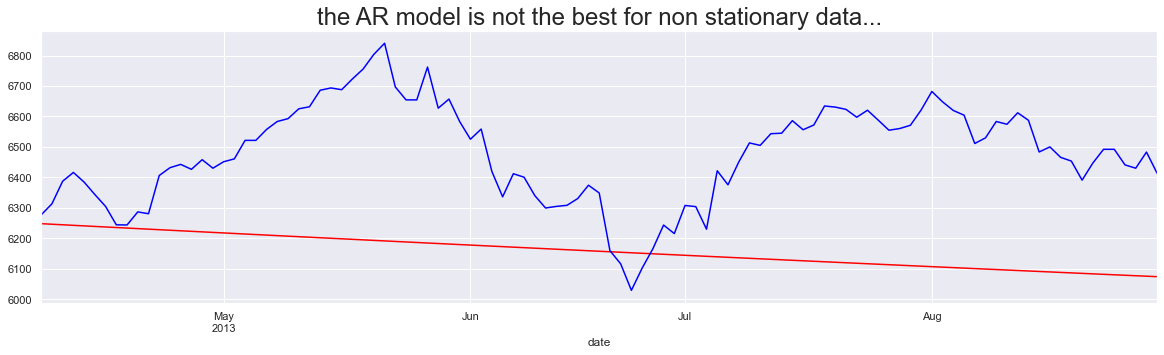

In [78]:
plot_pred(df_pred,df_test.ftse,title='the AR model is not the best for non stationary data...')


In [79]:
#returns
model_ret_ar = ARIMA(df.ret_ftse, order = (1,0,0))
res_ret_ar = model_ret_ar.fit()

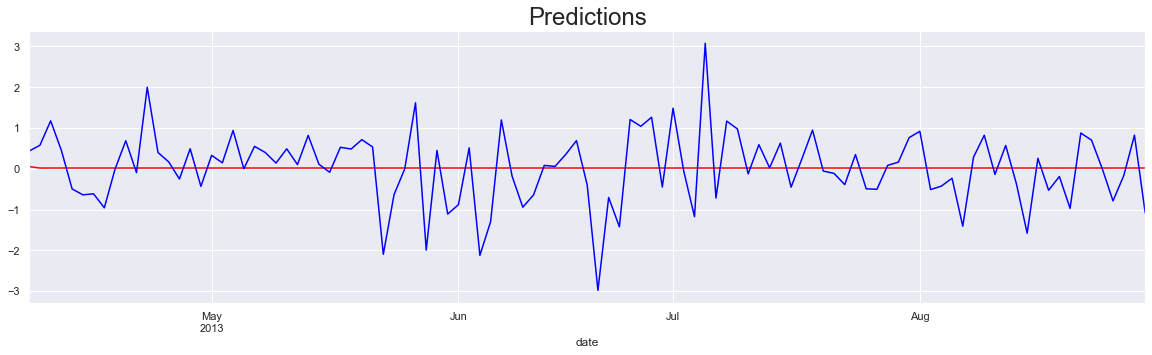

In [80]:
df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date)
plot_pred(df_ret_pred,df_test.ret_ftse)



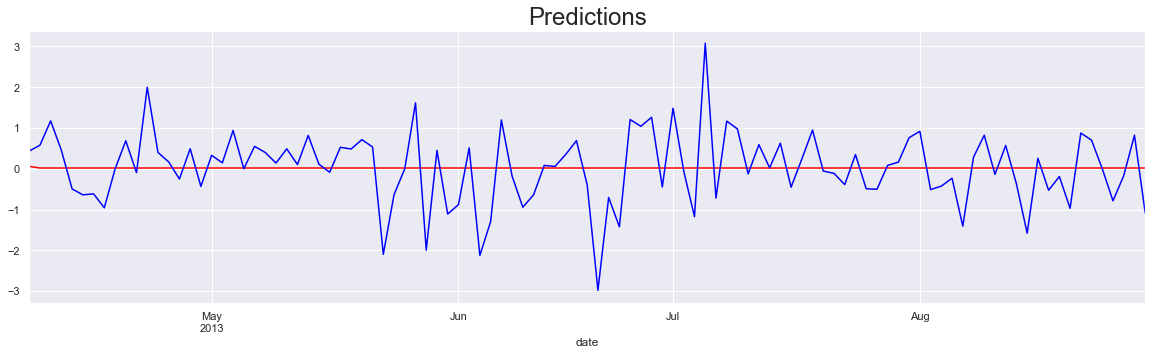

In [81]:
model_ret_ar = ARIMA(df.ret_ftse, order = (0,0,1))
res_ret_ar = model_ret_ar.fit()

df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date)
plot_pred(df_ret_pred,df_test.ret_ftse)



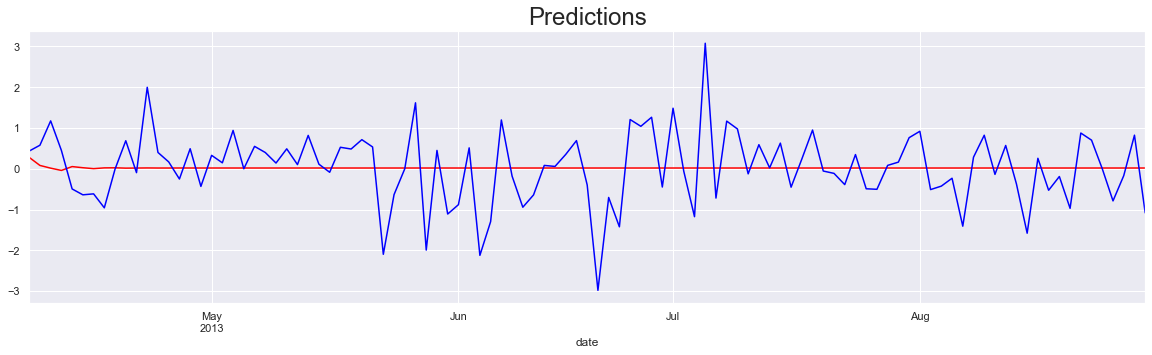

In [83]:
model_ret_ar = ARIMA(df.ret_ftse, order = (3,0,2))
res_ret_ar = model_ret_ar.fit()

df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date)

plot_pred(df_ret_pred,df_test.ret_ftse)

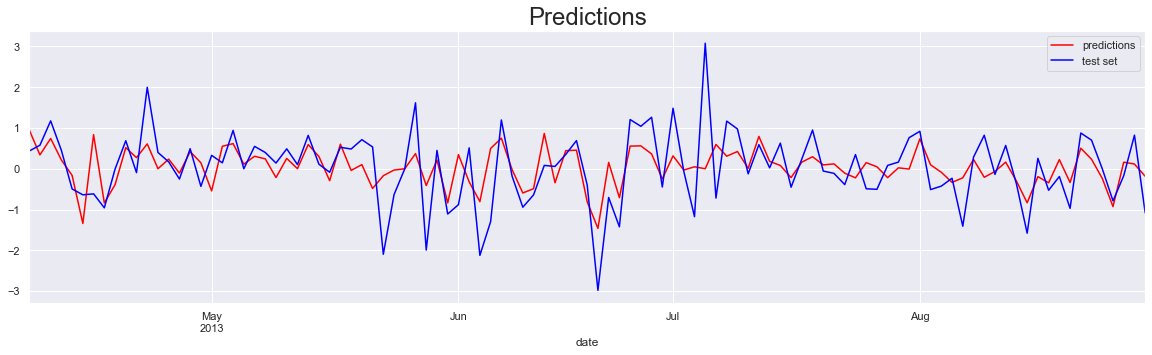

In [106]:
#armax
model_ret_ar = ARIMA(df.ret_ftse[1:], exog = df.ret_spx[1:], order = (1,0,1))
res_ret_ar = model_ret_ar.fit()

df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date, exog = df_test.ret_spx[start_date:end_date])

plot_pred(df_ret_pred,df_test.ret_ftse)

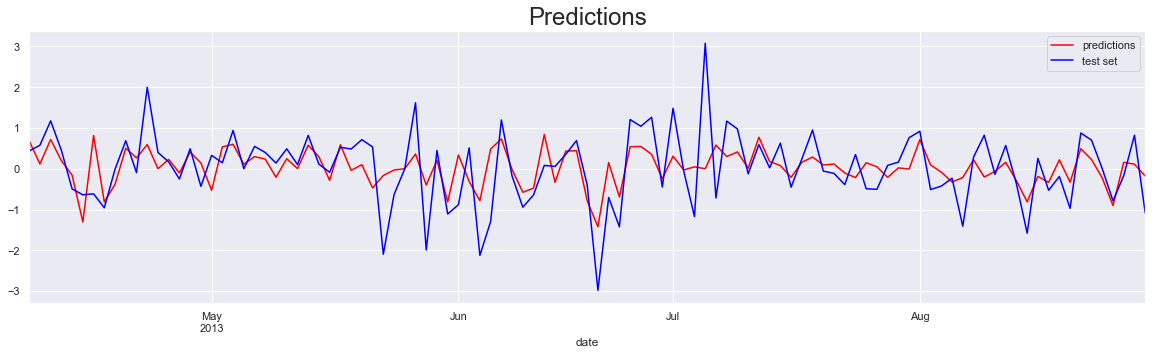

In [109]:
#arimax
model_ret_ar = ARIMA(df.ret_ftse[1:], exog = df.ret_spx[1:], order = (1,1,1))
res_ret_ar = model_ret_ar.fit()

df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date, exog = df_test.ret_spx[start_date:end_date])

plot_pred(df_ret_pred,df_test.ret_ftse)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


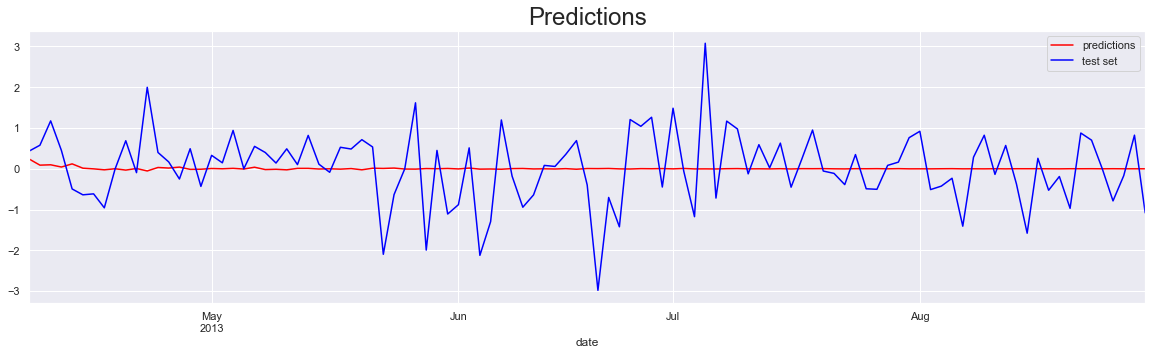

In [112]:
# sarma
model_ret_ar = SARIMAX(df.ret_ftse[1:], seasonal_order = (3,0,2,5), order = (3,0,4))
res_ret_ar = model_ret_ar.fit()

df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date)

plot_pred(df_ret_pred,df_test.ret_ftse)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


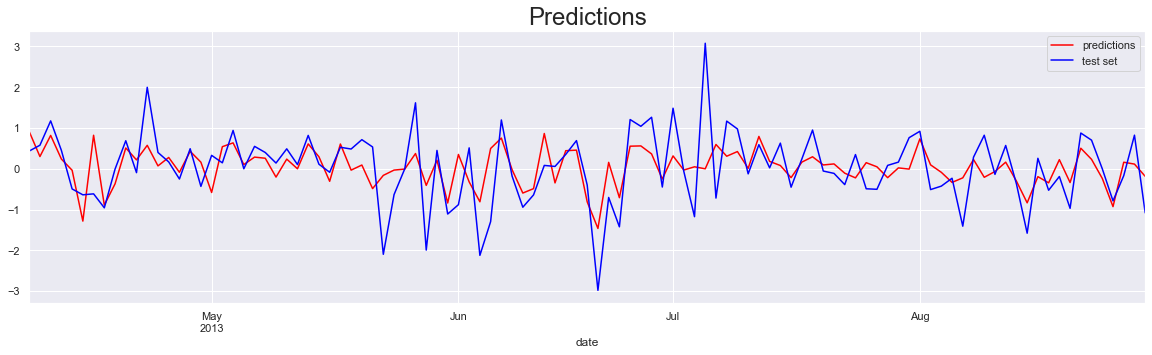

In [113]:
# sarimax
model_ret_ar = SARIMAX(df.ret_ftse[1:], exog = df.ret_spx[1:],  seasonal_order = (3,0,2,5), order = (3,0,4))
res_ret_ar = model_ret_ar.fit()

df_ret_pred = res_ret_ar.predict(start = start_date, end = end_date,  exog = df_test.ret_spx[start_date:end_date])

plot_pred(df_ret_pred,df_test.ret_ftse)

In [117]:
mod_auto

ARIMA(order=(0, 0, 3), out_of_sample_size=1255, scoring_args={},
      seasonal_order=(2, 0, 2, 5), suppress_warnings=True, trend='ct')

In [120]:
df_auto_pred = pd.DataFrame(mod_auto.predict(n_periods = len(df_test[start_date:end_date])),
                            index= df_test[start_date:end_date].index)




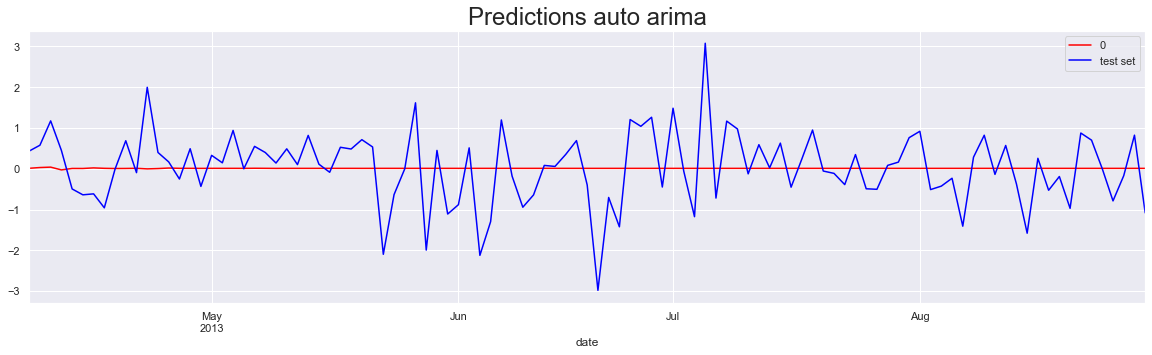

In [123]:
df_auto_pred.plot(figsize = (20,5), color = 'red', label='predictions')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue', label='test set')
plt.legend()
plt.title('Predictions auto arima', size=24)
plt.show()

I modelli fanno un po' tutti schifo a fare predictions. Per questo, potrebbe essere meglio stimare le volatilità invece delle previsioni puntuali.


In [126]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol ='GARCH', p=1, q=1,
                      mean='constant', dist ='Normal')

In [127]:
res_garch = mod_garch.fit(last_obs= start_date, update_freq=10)

Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189882
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


In [128]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')
# horizon = how many observations we want our model to predict for each date
# align = determines whether we match the value with the date the predition is made on, or the one it's supposed to represent


/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


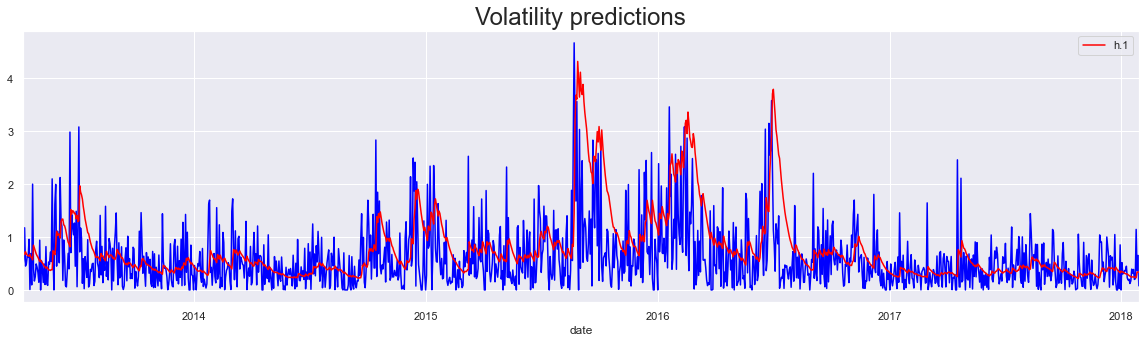

In [133]:
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), color='red', zorder = 2)
df_test.ret_ftse.abs().plot(color='blue', zorder=1)
plt.title('Volatility predictions', size=24)
plt.show()

In [135]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')

pred_garch.residual_variance[-1:]

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,0.343523,0.340599,0.354857,0.25736,0.274579,0.289543,0.300044,0.309239,0.313105,0.329072,...,0.924115,0.92664,0.944064,0.963335,0.981329,0.993313,0.958609,0.915886,0.925796,0.938776


## Multivariate Regression

Include many TS in the model in a vectorized form. for example, 
- Y_{t-1} [S&P, FTSE, DAX, NIKKEI] yields a VAR model
- if we add all the residues we have a VARMA, and so on..
- ..up to Vector SARIMAX

In [138]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [140]:
model_var = VAR(df_ret)
model_var.select_order(20)
results = model_var.fit(ic='aic')

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Oct, 2022
Time:                     12:08:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.475578
Nobs:                     5015.00    HQIC:                  0.404637
Log likelihood:          -29298.6    FPE:                    1.44248
AIC:                     0.366366    Det(Omega_mle):         1.41857
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.035821         0.017035            2.103           0.035
L1.ret_spx           -0.112626         0.018130           -6.212           0.000
L1.ret_dax            0.065624         0.019491           

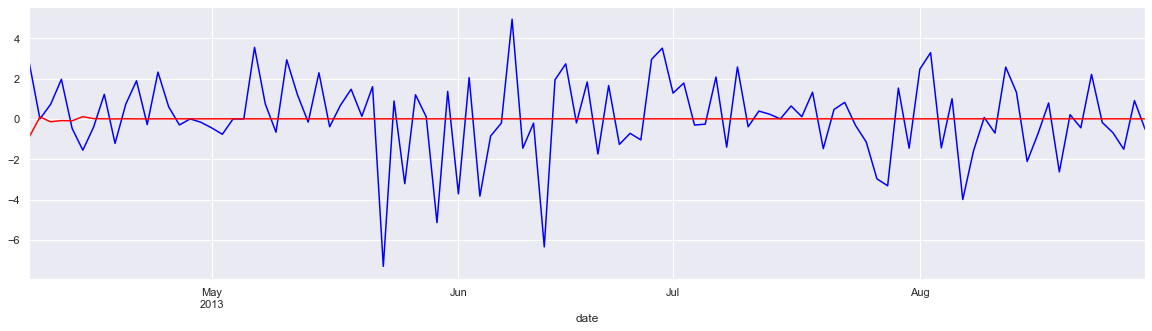

In [143]:
lag_order = results.k_ar

var_pred = results.forecast(df_ret.values[-lag_order:], len(df_test[start_date:end_date]))

df_pred = pd.DataFrame(data = var_pred, index = df_test[start_date:end_date].index,
                      columns = df_test[start_date:end_date].columns[4:8])

df_test.ret_nikkei[start_date:end_date].plot(figsize=(20,5), color='blue')
df_pred.ret_nikkei[start_date:end_date].plot(color='red')

plt.show()


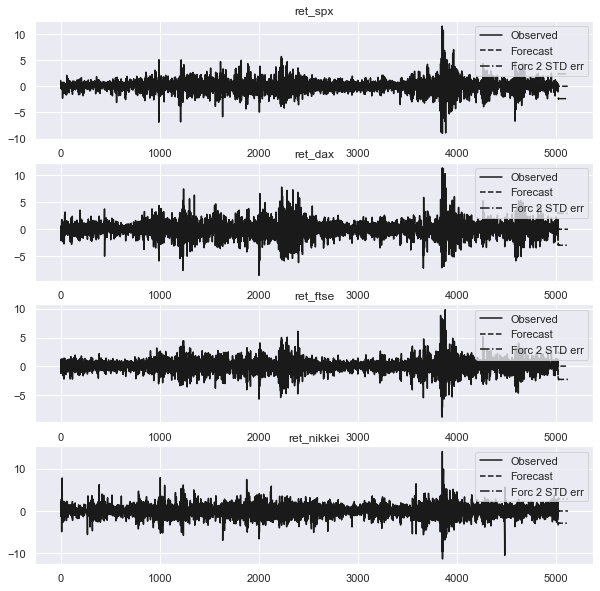

In [145]:
results.plot_forecast(100)
plt.show()